In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [3]:
font_size = 14
font_size_large= 20
sns.set_style('ticks')
colors = sns.color_palette()
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.size"] = font_size_large
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 1.5
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.major.width'] = 1.5

In [11]:
def load_data(csv_file):
    try:
        data = pd.read_csv(csv_file).to_dict(orient='list')
    except FileNotFoundError:
        print('WARNING! {} not found'.format(csv_file))
        return tuple([[]] * 9)
    
    bond_length = np.array(data['r'], dtype=float)
    vqe = data['vqe']
    fci = data['fci']
    mp2 = data['mp2']
    ccsd = data['ccsd']
    exact = data['exact']
    lower_bound = data['lower_bound']
    lower_bound0 = data['lower_bound0']
    upper_bound = data['upper_bound']
    fidelity = data['fidelity']
    
    # order
    ind_ordered = np.argsort(bond_length).astype(int)
    bond_length = np.array(bond_length)[ind_ordered]
    vqe = np.array(vqe, dtype=float)[ind_ordered]
    exact = np.array(exact, dtype=float)[ind_ordered]
    fci = np.array(fci, dtype=float)[ind_ordered]
    mp2 = np.array(mp2, dtype=float)[ind_ordered]
    ccsd = np.array(ccsd, dtype=float)[ind_ordered]
    lower_bound = np.array(lower_bound, dtype=float)[ind_ordered]
    lower_bound0 = np.array(lower_bound0, dtype=float)[ind_ordered]
    upper_bound = np.array(upper_bound, dtype=float)[ind_ordered]
    fidelity = np.array(fidelity, dtype=float)[ind_ordered]
    
    return bond_length, fci, mp2, ccsd, exact, vqe, lower_bound, lower_bound0, fidelity

In [106]:
def make_multi_plot(all_csv_files, all_ylim_fidelity, all_y_step_f, all_x_step, save_fn = None):
    # creates figures for multiple molecules
    
    num_molecules = len(all_csv_files)

    exact_color = 'black'

    fci_color = colors[3]
    mp2_color = colors[4]
    ccsd_color = colors[5]

    spa_color = colors[0]
    spas_color = colors[1]
    upccgsd_color = colors[2]
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 5*num_molecules))
    gs = fig.add_gridspec(5 * num_molecules, 2)
    gs.update(wspace=0.025, hspace=0.1)
    
    for i in range(num_molecules):
        
        csv_files = all_csv_files[i]
        ylim_fidelity = all_ylim_fidelity[i]
        y_step_f = all_y_step_f[i]
        x_step = all_x_step[i]

        for j, (csv_spa, csv_spas, csv_upccgsd) in enumerate(csv_files):

            # get data
            r, fci, mp2, ccsd, exact, vqe_spa, lower_bound_spa, _, fidelity_spa = load_data(csv_spa)
            r_spas, _, _, _, _, vqe_spas, lower_bound_spas, _, fidelity_spas = load_data(csv_spas)
            r_upccgsd, _, _, _, _, vqe_upccgsd, lower_bound_upccgsd, _, fidelity_upccgsd = load_data(csv_upccgsd)
            fci_nans = np.isfinite(fci)

            if len(r) == 0:
                continue

            # plot fidelity values
            ax2 = fig.add_subplot(gs[((i+1)*5 - 1), j])
            ax2.plot(r, fidelity_spa, label='SPA', linestyle='-', color=spa_color,
                     marker='x', markersize=4, zorder=1)
            ax2.plot(r_spas, fidelity_spas, label='SPA+S', linestyle='--', color=spas_color,
                     marker='x', markersize=4, zorder=1)
            ax2.plot(r_upccgsd, fidelity_upccgsd, label='UpCCGSD', linestyle='-.', color=upccgsd_color,
                     marker='*', markersize=4, zorder=1)

            if j == 0:
                ax2.set_ylabel('Fidelity')
            
            if i == num_molecules - 1:
                ax2.set_xlabel('Bond distance (Å)')
                
            ax2.set_ylim(ylim_fidelity)
            ax2.set_yticks(np.arange(start=round(ylim_fidelity[0], 2), stop=ylim_fidelity[1], step=y_step_f))
            ax2.set_xticks(np.arange(start=min(r), stop=max(r), step=x_step))
            ax2.xaxis.set_ticklabels(np.arange(start=min(r), stop=max(r), step=x_step))
#             ax2.grid()

            # plot energies
            ax1 = fig.add_subplot(gs[(5*i):((i+1)*5 - 1), j])

            # plot classical
            ax1.plot(r, exact, color='black', label=r'exact', linestyle='-', zorder=1)
            ax1.plot(r[fci_nans], fci[fci_nans], label=r'fci', linestyle='--', color=fci_color)
            ax1.plot(r, mp2, label=r'mp2', linestyle='--', zorder=1, color=mp2_color)
            ax1.plot(r, ccsd, label=r'ccsd', linestyle='--', zorder=1, color=ccsd_color)

            # plot vqe
            ax1.plot(r, vqe_spa, label='SPA (LB)', linestyle='-', color=spa_color, 
                     marker='x', markersize=6, zorder=1)
            ax1.plot(r_spas, vqe_spas, label='SPA+S (LB)', linestyle='--', color=spas_color, 
                     marker='+', markersize=6, zorder=1)
            ax1.plot(r_upccgsd, vqe_upccgsd, label='UpCCGSD (LB)', linestyle='-.', color=upccgsd_color,
                     marker='*', markersize=6, zorder=1)

            # plot bounds
            ax1.plot(r, lower_bound_spa, linestyle='', color=spa_color, marker='x', markersize=6, zorder=1)
            ax1.plot(r_spas, lower_bound_spas, linestyle='', color=spas_color, marker='+', markersize=6, zorder=1)
            ax1.plot(r_upccgsd, lower_bound_upccgsd, linestyle='', color=upccgsd_color, marker='*', 
                     markersize=6, zorder=1)

            # format axes
            ax1.set_xticks(np.arange(start=min(r), stop=max(r), step=x_step))
            ax1.xaxis.set_ticklabels([])
#             ax1.grid()

            if j == 0:
                ax1.set_ylabel('Energy')
                if i == 0:
                    ax1.set_title('Noiseless', fontsize=font_size_large + 4, pad = 15)
                            # annotate
                mol_name = r'H$_2$' if i == 0 else 'LiH'
                ax1.annotate(mol_name, xy=(0.1, 0.8),  xycoords='axes fraction', fontsize=font_size_large + 10)
            else:
                if i == 0:
                    ax1.set_title('Depolarization + BitFlip Noise', fontsize=font_size_large + 4, pad=15)

            handles, labels = ax1.get_legend_handles_labels()
            
            if i == num_molecules - 1 and j == 0:
                ax1.legend(handles, labels, loc='upper right', ncol=2, fontsize=14, framealpha=0.75)

#     _ = fig.legend(handles, labels, loc='upper center', fancybox=False, facecolor='white', ncol=7, fontsize = 16,
#                   bbox_to_anchor=(0.5, 1.05))
    
    if save_fn is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, save_fn), dpi=250, bbox_inches='tight', pad_inches=0.1)
        


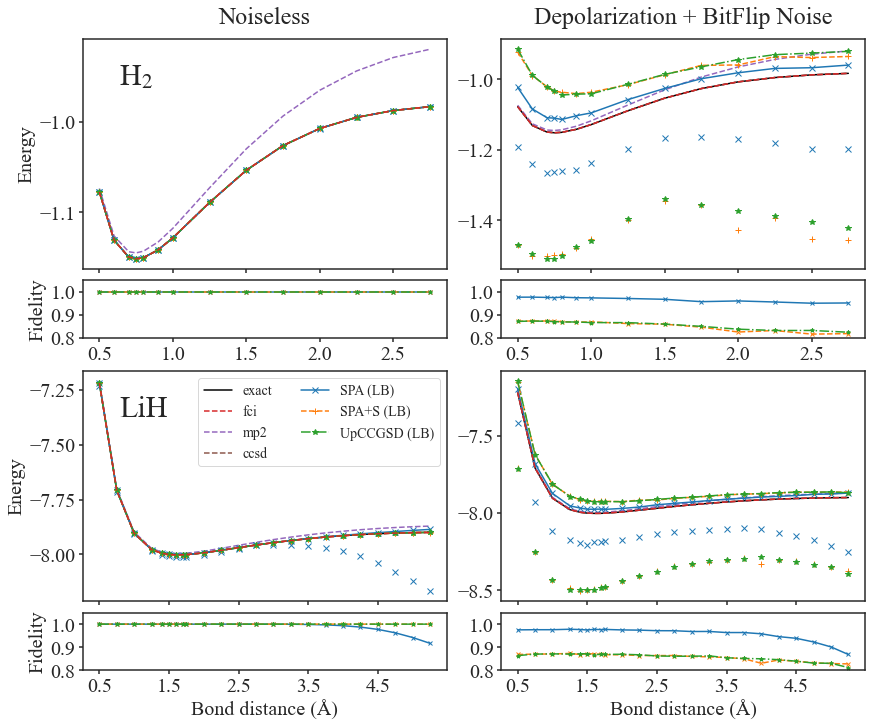

In [109]:
h2_csv_files = [
    # noiseless csv files
    ('results/h2/basis-set-free/hcb=False/spa/noise=0/results.csv',
    'results/h2/basis-set-free/hcb=False/spa-s/noise=0/results.csv',
    'results/h2/basis-set-free/hcb=False/upccgsd/noise=0/results.csv'),
    # noisy csv files
    ('results/h2/basis-set-free/hcb=False/spa/noise=1/results.csv', 
     'results/h2/basis-set-free/hcb=False/spa-s/noise=1/results.csv',
     'results/h2/basis-set-free/hcb=False/upccgsd/noise=1/results.csv')
]

lih_csv_files = [
    # noiseless csv files
    ('results/lih/basis-set-free/hcb=False/spa/noise=0/results.csv',
    'results/lih/basis-set-free/hcb=False/spa-s/noise=0/results.csv',
    'results/lih/basis-set-free/hcb=False/upccgsd/noise=0/results.csv'),
    # noisy csv files
    ('results/lih/basis-set-free/hcb=False/spa/noise=1/results.csv', 
     'results/lih/basis-set-free/hcb=False/spa-s/noise=1/results.csv',
     'results/lih/basis-set-free/hcb=False/upccgsd/noise=1/results.csv')
]

ylim_fidelity_h2 = (0.8, 1.05)
ylim_fidelity_lih = (0.8, 1.05)

y_step_f_h2 = 0.1
y_step_f_lih = 0.1

x_step_h2 = 0.5
x_step_lih = 1

make_multi_plot([h2_csv_files, lih_csv_files],
                [ylim_fidelity_h2, ylim_fidelity_lih],
                [y_step_f_h2, y_step_f_lih],
                [x_step_h2, x_step_lih], save_fn='h2_lih.pdf')

## Plot BeH2

In [19]:
def plot_beh2(csv_files, ylim_fidelity, ylim_energy1, ylim_energy2, y_step_f=0.1, x_step=0.5, save_fn = None):

    exact_color = 'black'

    fci_color = colors[3]
    mp2_color = colors[4]
    ccsd_color = colors[5]

    spa_color = colors[0]
    spas_color = colors[1]
    upccgsd_color = colors[2]
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 9))
    gs = fig.add_gridspec(9, 2)
    gs.update(wspace=0.025, hspace=0.1)

    for j, (csv_spa, csv_spas, csv_upccgsd) in enumerate(csv_files):

        # get data
        r, fci, mp2, ccsd, exact, vqe_spa, lower_bound_spa, _, fidelity_spa = load_data(csv_spa)
        r_spas, _, _, _, _, vqe_spas, lower_bound_spas, _, fidelity_spas = load_data(csv_spas)
        r_upccgsd, _, _, _, _, vqe_upccgsd, lower_bound_upccgsd, _, fidelity_upccgsd = load_data(csv_upccgsd)
        fci_nans = np.isfinite(fci)
        
        if len(r) == 0:
            continue
            
        # plot energies + lower bound
        ax1 = fig.add_subplot(gs[:4, j])

        # plot classical
        ax1.plot(r, exact, color='black', label=r'exact', linestyle='-', zorder=1)
        ax1.plot(r[fci_nans], fci[fci_nans], label=r'fci', linestyle='--', color=fci_color)
        ax1.plot(r, mp2, label=r'mp2', linestyle='--', zorder=1, color=mp2_color)
        ax1.plot(r, ccsd, label=r'ccsd', linestyle='--', zorder=1, color=ccsd_color)

        # plot vqe
        ax1.plot(r, vqe_spa, label='SPA (LB)', linestyle='-', color=spa_color, marker='x', markersize=6, zorder=1)
        ax1.plot(r_spas, vqe_spas, label='SPA+S (LB)', linestyle='--', color=spas_color, marker='+', markersize=6, zorder=1)
        ax1.plot(r_upccgsd, vqe_upccgsd, label='UpCCGSD (LB)', linestyle='-.', color=upccgsd_color, marker='*', markersize=6, zorder=1)

        # plot bounds
        ax1.plot(r, lower_bound_spa, linestyle='', color=spa_color, marker='x', markersize=6, zorder=1)
        ax1.plot(r_spas, lower_bound_spas, linestyle='', color=spas_color, marker='+', markersize=6, zorder=1)
        ax1.plot(r_upccgsd, lower_bound_upccgsd, linestyle='', color=upccgsd_color, marker='*', markersize=6, zorder=1)

        # format axes
        ax1.set_ylim(ylim_energy1)
        ax1.set_xticks(np.arange(start=min(r), stop=max(r), step=x_step))
        ax1.xaxis.set_ticklabels([])
#         ax1.grid()
            
        # plot only energies
        ax2 = fig.add_subplot(gs[4:8, j])
        
        # plot classical
        ax2.plot(r, exact, color='black', label=r'exact', linestyle='-', zorder=1)
        ax2.plot(r[fci_nans], fci[fci_nans], label=r'fci', linestyle='--', color=fci_color)
        ax2.plot(r, mp2, label=r'mp2', linestyle='--', zorder=1, color=mp2_color)
        ax2.plot(r, ccsd, label=r'ccsd', linestyle='--', zorder=1, color=ccsd_color)

        # plot vqe
        ax2.plot(r, vqe_spa, label='SPA', linestyle='-', color=spa_color, marker='x', markersize=6, zorder=1)
        ax2.plot(r_spas, vqe_spas, label='SPA+S', linestyle='--', color=spas_color, marker='+', markersize=6, zorder=1)
        ax2.plot(r_upccgsd, vqe_upccgsd, label='UpCCGSD', linestyle='-.', color=upccgsd_color, marker='*', markersize=6)
#         ax2.grid()
        
        # format axes
        ax2.set_xticks(np.arange(start=min(r), stop=max(r), step=x_step))
        ax2.xaxis.set_ticklabels([])
        ax2.set_ylim(ylim_energy2)

        # plot fidelity values
        ax3 = fig.add_subplot(gs[8, j])
        ax3.plot(r, fidelity_spa, label='SPA', linestyle='-', color=spa_color, marker='x', markersize=4, zorder=1)
        ax3.plot(r_spas, fidelity_spas, label='SPA+S', linestyle='--', color=spas_color, marker='x', markersize=4, zorder=1)
        ax3.plot(r_upccgsd, fidelity_upccgsd, label='UpCCGSD', linestyle='-.', color=upccgsd_color, marker='*', markersize=4, zorder=1)

        ax3.set_xlabel('Bond distance (Å)')
        ax3.set_ylim(ylim_fidelity)
        ax3.set_yticks(np.arange(start=round(ylim_fidelity[0], 2), stop=ylim_fidelity[1], step=y_step_f))
        ax3.set_xticks(np.arange(start=min(r), stop=max(r), step=x_step))
        ax3.xaxis.set_ticklabels(np.arange(start=min(r), stop=max(r), step=x_step))
#         ax3.grid()

        handles, labels = ax1.get_legend_handles_labels()
        
        if j == 0:
            ax1.set_ylabel('Energy')
            ax2.set_ylabel('Energy')
            ax1.set_title('Noiseless', fontsize=font_size_large + 4, pad = 15)
            ax1.legend(handles, labels, loc='best', ncol=1, fontsize=14, framealpha=0.75)
            ax3.set_ylabel('Fidelity')
            
            # annotate
            ax2.annotate(r'BeH$_2$', xy=(0.1, 0.8),  xycoords='axes fraction', fontsize=font_size_large + 10)
        else:
            ax1.set_title('Depolarization + BitFlip Noise', fontsize=font_size_large + 4, pad = 15)
            ax1.yaxis.set_ticklabels([])
            ax2.yaxis.set_ticklabels([])
            ax3.yaxis.set_ticklabels([])

#     _ = fig.legend(handles, labels, loc='upper center', fancybox=False, facecolor='white', ncol=7, fontsize = 16,
#               bbox_to_anchor=(0.5, 1.1))
    
    if save_fn is not None:
        save_dir = '/Users/maurice/Dropbox/Apps/Overleaf/[Quantum] NISQ Performance Guarantees/figures'
        plt.savefig(os.path.join(save_dir, save_fn), dpi=250, bbox_inches='tight', pad_inches=0.1)

WARNING! ../results/beh2/basis-set-free/hcb=False/upccgsd/noise=1/results.csv not found


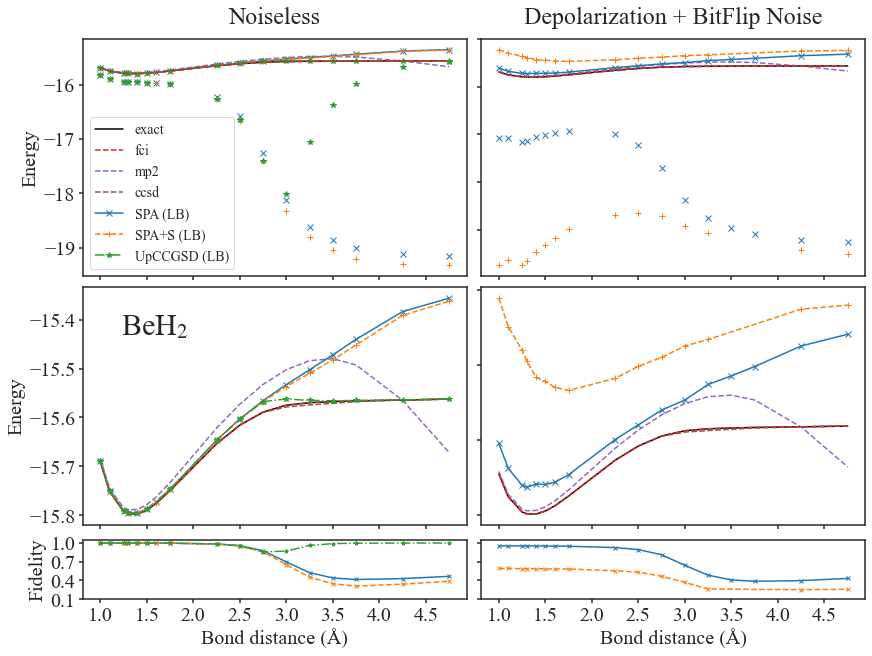

In [24]:
beh2_csv_files = [
    # noiseless csv files
    ('../results/beh2/basis-set-free/hcb=False/spa/noise=0/results.csv',
    '../results/beh2/basis-set-free/hcb=False/spa-s/noise=0/results.csv',
    '../results/beh2/basis-set-free/hcb=False/upccgsd/noise=0/results.csv'),
    # noisy csv files
    ('../results/beh2/basis-set-free/hcb=False/spa/noise=1/results.csv', 
     '../results/beh2/basis-set-free/hcb=False/spa-s/noise=1/results.csv',
     '../results/beh2/basis-set-free/hcb=False/upccgsd/noise=1/results.csv')
]

ylim_fidelity_beh2 = (0.1, 1.05)
y_step_f_beh2 = 0.3
x_step_beh2 = 0.5
ylim_energy1 = None #(-19.9, -15)
ylim_energy2 = None #(-15.9, -15.2)

plot_beh2(beh2_csv_files, ylim_fidelity_beh2, ylim_energy1, ylim_energy2, y_step_f=y_step_f_beh2, x_step=0.5, 
          save_fn=None) #'beh2.pdf')

# --- BELOW IS OLD ---

In [14]:
def make_plot(csv_files, ylim_fidelity, y_step_f=0.1, x_step=0.5, save_fn = None):
    # creates figures for a single molecule

    exact_color = 'black'

    fci_color = colors[3]
    mp2_color = colors[4]
    ccsd_color = colors[5]

    spa_color = colors[0]
    spas_color = colors[1]
    upccgsd_color = colors[2]
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 6))
    gs = fig.add_gridspec(5, 2)
    gs.update(wspace=0.025, hspace=0.1)

    for j, (csv_spa, csv_spas, csv_upccgsd) in enumerate(csv_files):

        # get data
        r, fci, mp2, ccsd, exact, vqe_spa, lower_bound_spa, _, fidelity_spa = load_data(csv_spa)
        r_spas, _, _, _, _, vqe_spas, lower_bound_spas, _, fidelity_spas = load_data(csv_spas)
        r_upccgsd, _, _, _, _, vqe_upccgsd, lower_bound_upccgsd, _, fidelity_upccgsd = load_data(csv_upccgsd)
        fci_nans = np.isfinite(fci)
        
        if len(r) == 0:
            continue

        # plot fidelity values
        ax1 = fig.add_subplot(gs[4, j])
        ax1.plot(r, fidelity_spa, label='SPA', linestyle='-', color=spa_color, marker='x', markersize=4, zorder=1)
        ax1.plot(r_spas, fidelity_spas, label='SPA+S', linestyle='--', color=spas_color, marker='x', markersize=4, zorder=1)
        ax1.plot(r_upccgsd, fidelity_upccgsd, label='UpCCGSD', linestyle='-.', color=upccgsd_color, marker='*', markersize=4, zorder=1)

        if j == 0:
            ax1.set_ylabel('Fidelity')

        ax1.set_xlabel('Bond distance (Å)')
        ax1.set_ylim(ylim_fidelity)
        ax1.set_yticks(np.arange(start=round(ylim_fidelity[0], 2), stop=ylim_fidelity[1], step=y_step_f))
        ax1.set_xticks(np.arange(start=min(r), stop=max(r), step=x_step))
        ax1.xaxis.set_ticklabels(np.arange(start=min(r), stop=max(r), step=x_step))
        ax1.grid()

        # plot energies
        ax2 = fig.add_subplot(gs[:4, j])

        # plot classical
        ax2.plot(r, exact, color='black', label=r'exact', linestyle='-', zorder=1)
        ax2.plot(r[fci_nans], fci[fci_nans], label=r'fci', linestyle='--', color=fci_color)
        ax2.plot(r, mp2, label=r'mp2', linestyle='--', zorder=1, color=mp2_color)
        ax2.plot(r, ccsd, label=r'ccsd', linestyle='--', zorder=1, color=ccsd_color)

        # plot vqe
        ax2.plot(r, vqe_spa, label='SPA (LB)', linestyle='-', color=spa_color, marker='x', markersize=6, zorder=1)
        ax2.plot(r_spas, vqe_spas, label='SPA+S (LB)', linestyle='--', color=spas_color, marker='+', markersize=6, zorder=1)
        ax2.plot(r_upccgsd, vqe_upccgsd, label='UpCCGSD (LB)', linestyle='-.', color=upccgsd_color, marker='*', markersize=6, zorder=1)

        # plot bounds
        ax2.plot(r, lower_bound_spa, linestyle='', color=spa_color, marker='x', markersize=6, zorder=1)
        ax2.plot(r_spas, lower_bound_spas, linestyle='', color=spas_color, marker='+', markersize=6, zorder=1)
        ax2.plot(r_upccgsd, lower_bound_upccgsd, linestyle='', color=upccgsd_color, marker='*', markersize=6, zorder=1)

        # format axes
        ax2.set_xticks(np.arange(start=min(r), stop=max(r), step=x_step))
        ax2.xaxis.set_ticklabels([])
        ax2.grid()

        if j == 0:
            ax2.set_ylabel('Energy')
            ax2.set_title('Noiseless', fontsize=font_size_large)
        else:
            ax2.set_title('Depolarization + BitFlip Noise', fontsize=font_size_large)

        handles, labels = ax2.get_legend_handles_labels()

    _ = fig.legend(handles, labels, loc='upper center', fancybox=False, facecolor='white', ncol=7, fontsize = 16,
              bbox_to_anchor=(0.5, 1.1))
    
    if save_fn is not None:
        save_dir = './plots'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, save_fn), dpi=250, bbox_inches='tight', pad_inches=0.1)

## H2 Plots

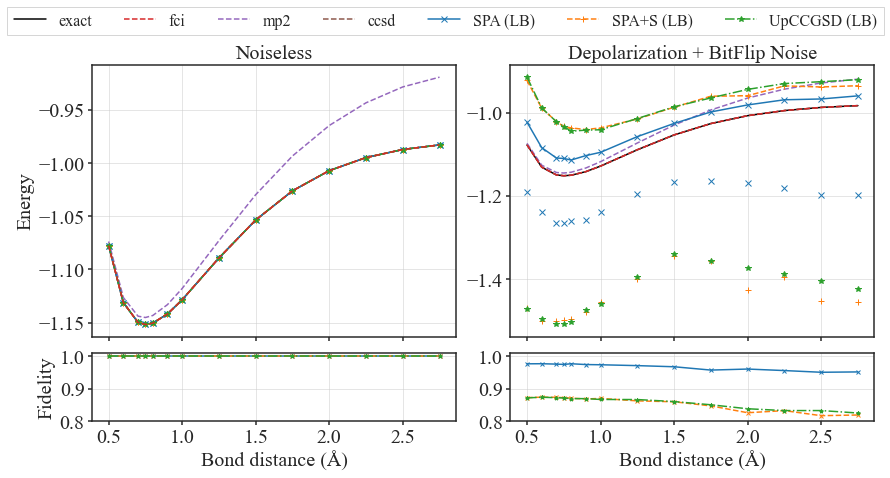

In [15]:
csv_files = [
    # noiseless csv files
    ('../results/h2/basis-set-free/hcb=False/spa/noise=0/results.csv',
    '../results/h2/basis-set-free/hcb=False/spa-s/noise=0/results.csv',
    '../results/h2/basis-set-free/hcb=False/upccgsd/noise=0/results.csv'),
    # noisy csv files
    ('../results/h2/basis-set-free/hcb=False/spa/noise=1/results.csv', 
     '../results/h2/basis-set-free/hcb=False/spa-s/noise=1/results.csv',
     '../results/h2/basis-set-free/hcb=False/upccgsd/noise=1/results.csv')
]

ylim_fidelity = (0.8, 1.01)

make_plot(csv_files, ylim_fidelity=ylim_fidelity, save_fn=None) #'h2_figures.pdf')

## LiH Plots

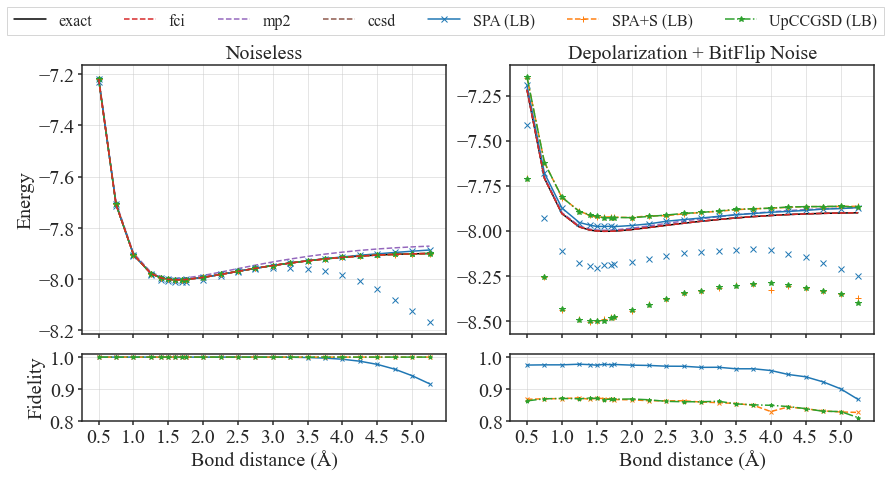

In [17]:
csv_files = [
    # noiseless csv files
    ('../results/lih/basis-set-free/hcb=False/spa/noise=0/results.csv',
    '../results/lih/basis-set-free/hcb=False/spa-s/noise=0/results.csv',
    '../results/lih/basis-set-free/hcb=False/upccgsd/noise=0/results.csv'),
    # noisy csv files
    ('../results/lih/basis-set-free/hcb=False/spa/noise=1/results.csv', 
     '../results/lih/basis-set-free/hcb=False/spa-s/noise=1/results.csv',
     '../results/lih/basis-set-free/hcb=False/upccgsd/noise=1/results.csv')
]

ylim_fidelity = (0.8, 1.01)

make_plot(csv_files, ylim_fidelity=ylim_fidelity, y_step_f=0.1, x_step=0.5, save_fn=None) #'lih_figures.pdf')